In [1]:
import pandas as pd
import matplotlib.pylab as plt


In [6]:
df = pd.read_csv('result_gemini_final.csv')
#df_usa = df[df['location'].str.contains('USA', na=False)]
# load 2019_ridgecrest_DYFI.csv, the zipcode column is in str dtype     
df2 = pd.read_csv('/Users/zihuima/Desktop/LLM_earthquake/2019_ridgecrest_DYFI.csv', dtype={'Zip Code': str})
# Roman numeral to integer mapping for MMI scale
mmi_mapping = {
    'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5,
    'VI': 6, 'VII': 7, 'VIII': 8, 'IX': 9, 'X': 10,
    'XI': 11, 'XII': 12
}

# Apply the mapping to the MMI column
df2['MMI_numeric'] = df2['MMI'].map(mmi_mapping)

/var/folders/16/1vd8ng7110b2d_r29trv5qwh0000gn/T/ipykernel_77017/45528750.py:1: DtypeWarning: Columns (20,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('result_gemini_final.csv')


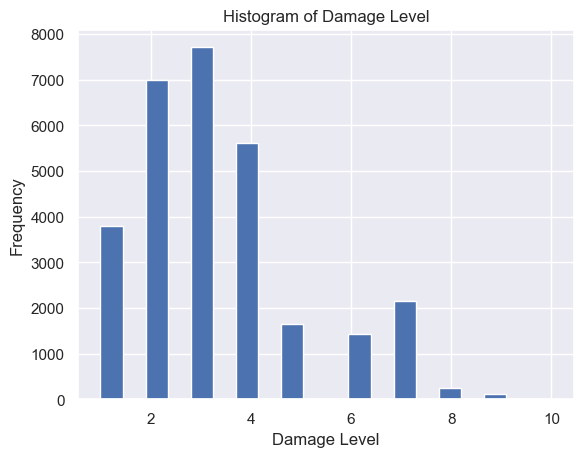

In [7]:
# plot column damage_level without nan
df['damage_level'].dropna().hist(bins=20)
plt.xlabel('Damage Level')
plt.ylabel('Frequency')
plt.title('Histogram of Damage Level')
plt.show()  

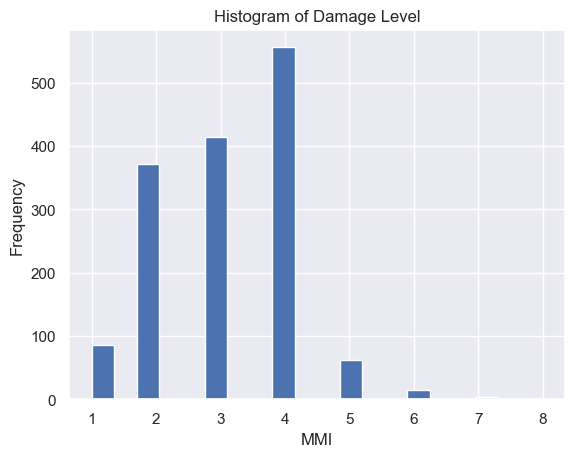

In [8]:
# plot column MMI metric without nan
df2['MMI_numeric'].dropna().hist(bins=20)
plt.xlabel('MMI')
plt.ylabel('Frequency')
plt.title('Histogram of Damage Level')
plt.show()  


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Set the Seaborn theme
sns.set_theme(style="darkgrid")

# Ensure damage_level is numeric
df['damage_level'] = pd.to_numeric(df['damage_level'], errors='coerce')

# Group by city: average damage_level from LLM
llava_city = df.groupby('location_response_city', as_index=False)['damage_level'].mean()


# Group by city: average MMI from DYFI (using numeric MMI)
dyfi_city = df2.groupby('City', as_index=False)['MMI_numeric'].mean()

# Merge on city name (adjust column names if needed)
merged = pd.merge(llava_city, dyfi_city, left_on='location_response_city', right_on='City')




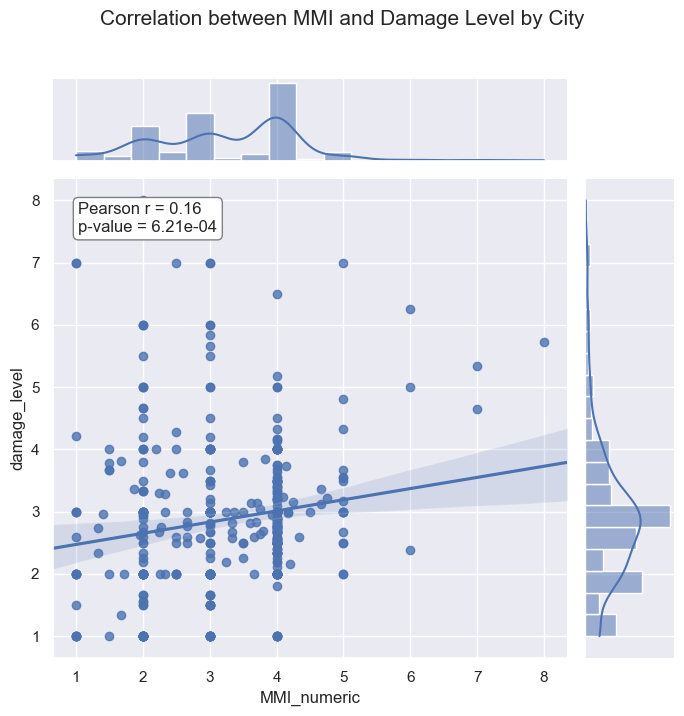

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

def annotate_corr_scatter(x, y, ax, label="Pearson r"):
    # Remove NaNs for correlation calculation
    mask = (~pd.isnull(x)) & (~pd.isnull(y))
    r, pval = pearsonr(x[mask], y[mask])
    ax.annotate(f"{label} = {r:.2f}\np-value = {pval:.2e}",
                xy=(0.05, 0.95),
                xycoords='axes fraction',
                ha='left', va='top',
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

# Create the jointplot
g = sns.jointplot(
    x="MMI_numeric",
    y="damage_level",
    data=merged,
    kind="reg",
    truncate=False,
    color="b",
    height=7
)


# Add title
plt.suptitle("Correlation between MMI and Damage Level by City", fontsize=15, y=1.02)

# Add correlation annotation using our function
annotate_corr_scatter(merged['MMI_numeric'], merged['damage_level'], g.ax_joint)


plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
from geopy.geocoders import Nominatim
import time

# 1. Aggregate: average damage_level per city from LLM
df['damage_level'] = pd.to_numeric(df['damage_level'], errors='coerce')
llava_city = df.groupby('location_response_city', as_index=False)['damage_level'].mean()

# 2. Aggregate: average MMI_numeric per city from DYFI
df2['MMI_numeric'] = pd.to_numeric(df2['MMI_numeric'], errors='coerce')
dyfi_city = df2.groupby('City', as_index=False)['MMI_numeric'].mean()

# 3. Merge on city name
merged = pd.merge(
    llava_city,
    dyfi_city,
    left_on='location_response_city',
    right_on='City'
)

# 4. Geocode each city to get latitude and longitude
geolocator = Nominatim(user_agent="city_geocoder")
latitudes = []
longitudes = []

for city in merged['location_response_city']:
    try:
        location = geolocator.geocode(f"{city}, California, USA", timeout=10)
        if location:
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
        else:
            latitudes.append(None)
            longitudes.append(None)
    except Exception as e:
        latitudes.append(None)
        longitudes.append(None)
    time.sleep(1)  # To avoid hitting the geocoding rate limit

merged['latitude'] = latitudes
merged['longitude'] = longitudes

# Drop cities where geocoding failed
merged = merged.dropna(subset=['latitude', 'longitude'])

# Keep only the relevant columns
merged = merged[['location_response_city', 'MMI_numeric', 'damage_level', 'latitude', 'longitude']]

# Save to CSV
merged.to_csv('merged_city_damage_mmi_latlon.csv', index=False)
print("Saved as merged_city_damage_mmi_latlon.csv")

Saved as merged_city_damage_mmi_latlon.csv


In [54]:
merged = pd.read_csv('merged_city_damage_mmi_latlon.csv')
print(merged.head())

  location_response_city  MMI_numeric  damage_level   latitude   longitude
0                  Acton          4.0      3.000000  34.480742 -118.186838
1               Adelanto          5.0      3.000000  34.583808 -117.408245
2           Agoura Hills          3.0      3.000000  34.148169 -118.765546
3                Alameda          1.5      3.666667  37.609029 -121.899142
4                 Albany          1.0      1.000000  37.887162 -122.298351


city less than 1, equally

In [57]:
 #Calculate absolute difference
merged['abs_diff'] = abs(merged['MMI_numeric'] - merged['damage_level'])

 #Create a copy of the data
adjusted_data = merged.copy()

# For points where difference < 1, set damage_level = MMI_numeric
adjusted_data.loc[adjusted_data['abs_diff'] < 1, 'damage_level'] = adjusted_data.loc[adjusted_data['abs_diff'] < 1, 'MMI_numeric']

In [58]:
print(adjusted_data)

     location_response_city  MMI_numeric  damage_level   latitude   longitude  \
0                     Acton     4.000000      3.000000  34.480742 -118.186838   
1                  Adelanto     5.000000      3.000000  34.583808 -117.408245   
2              Agoura Hills     3.000000      3.000000  34.148169 -118.765546   
3                   Alameda     1.500000      3.666667  37.609029 -121.899142   
4                    Albany     1.000000      1.000000  37.887162 -122.298351   
..                      ...          ...           ...        ...         ...   
443  Yosemite National Park     3.000000      3.000000  37.839300 -119.516464   
444               Yuba City     2.500000      2.500000  39.140448 -121.616911   
445                 Yucaipa     4.000000      4.000000  34.033625 -117.043087   
446            Yucca Valley     4.000000      2.000000  34.123621 -116.413984   
447                    Yuma     2.666667      2.666667  32.779170 -114.634680   

     abs_diff  
0    1.0000

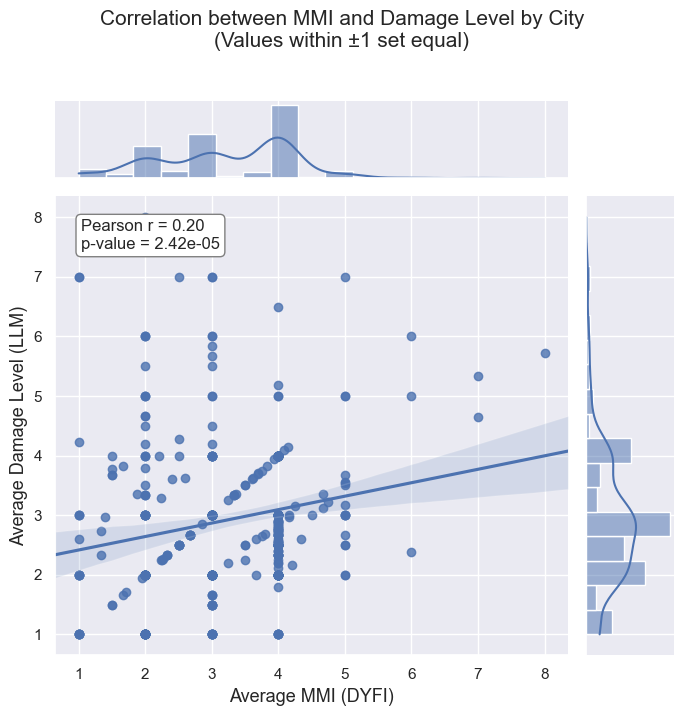

In [59]:
 #Create the jointplot
g = sns.jointplot(
    x="MMI_numeric",
    y="damage_level",
    data=adjusted_data,
    kind="reg",
    truncate=False,
    color="b",
    height=7
)

# Set axis labels
g.set_axis_labels("Average MMI (DYFI)", "Average Damage Level (LLM)", fontsize=13)

# Add title
plt.suptitle("Correlation between MMI and Damage Level by City\n(Values within ±1 set equal)", fontsize=15, y=1.02)

# Add correlation annotation using our function
annotate_corr_scatter(adjusted_data['MMI_numeric'], adjusted_data['damage_level'], g.ax_joint)

plt.tight_layout()
plt.show()


Generate county name

In [39]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

# First, make sure you have the merged dataframe with lat/long
# If you don't have it yet, you'll need to run the previous lat/long generation code first
# Read your existing merged file
merged = pd.read_csv('merged_city_damage_mmi_latlon.csv')

def get_county(lat, lon):
    try:
        geolocator = Nominatim(user_agent="county_finder")
        location = geolocator.reverse(f"{lat}, {lon}", exactly_one=True)
        if location and location.raw.get('address'):
            return location.raw['address'].get('county')
        return None
    except Exception as e:
        print(f"Error getting county for {lat}, {lon}: {str(e)}")
        return None

# Add county column
print("Generating county information...")
merged['county'] = None

# Process in batches to avoid rate limiting
batch_size = 50
total_rows = len(merged)

for i in range(0, total_rows, batch_size):
    batch = merged.iloc[i:i+batch_size]
    for idx, row in batch.iterrows():
        if pd.notna(row['latitude']) and pd.notna(row['longitude']):
            county = get_county(row['latitude'], row['longitude'])
            merged.at[idx, 'county'] = county
    print(f"Processed {min(i+batch_size, total_rows)}/{total_rows} rows")
    time.sleep(1)  # Add delay to avoid rate limiting

# Save the updated dataframe
merged.to_csv('merged_city_damage_mmi_location.csv', index=False)

# Display the first few rows to verify
print("\nFirst few rows of the updated dataframe:")
print(merged[['location_response_city', 'latitude', 'longitude', 'county']].head())

Generating county information...
Processed 50/448 rows
Processed 100/448 rows
Processed 150/448 rows


KeyboardInterrupt: 

In [41]:
print(merged.head())

  location_response_city  MMI_numeric  damage_level   latitude   longitude  \
0                  Acton          4.0      3.000000  34.480742 -118.186838   
1               Adelanto          5.0      3.000000  34.583808 -117.408245   
2           Agoura Hills          3.0      3.000000  34.148169 -118.765546   
3                Alameda          1.5      3.666667  37.609029 -121.899142   
4                 Albany          1.0      1.000000  37.887162 -122.298351   

                  county  
0     Los Angeles County  
1  San Bernardino County  
2     Los Angeles County  
3         Alameda County  
4         Alameda County  


In [42]:
# Group by county and calculate mean values
county_data = merged.groupby('county', as_index=False).agg({
    'MMI_numeric': 'mean',
    'damage_level': 'mean'
}).dropna()  # Remove any rows with NaN values

In [43]:
print(county_data.head())

                county  MMI_numeric  damage_level
0       Alameda County     1.828472      2.224439
1        Amador County     3.000000      4.500000
2         Butte County     1.555556      4.144444
3         Clark County     3.000000      5.833333
4  Contra Costa County     1.923077      2.517094


In [44]:
# Filter for California counties
# First, let's see what counties we have
print("All counties in the dataset:")
print(merged['county'].unique())

All counties in the dataset:
['Los Angeles County' 'San Bernardino County' 'Alameda County'
 'San Diego County' 'Orange County' 'Santa Cruz County' 'Kern County'
 'San Luis Obispo County' 'Fresno County' 'Riverside County'
 'Madera County' 'Solano County' 'Inyo County' 'Clark County'
 'Imperial County' 'Contra Costa County' 'San Mateo County'
 'Ventura County' 'Sacramento County' 'Santa Barbara County'
 'Stanislaus County' 'Butte County' 'Tuolumne County' 'Kings County'
 'Santa Clara County' 'Yolo County' 'Tulare County' 'Marin County'
 'El Dorado County' 'Mendocino County' 'Shasta County' 'Placer County'
 'San Benito County' 'Amador County' 'Monterey County' 'Klamath County'
 'Merced County' 'San Joaquin County' 'Modoc County' 'Mono County'
 'Yuba County' 'Mariposa County' 'Sonoma County' 'Napa County'
 'Nye County' 'Lassen County' 'Salt Lake County' nan 'Siskiyou County'
 'Snohomish County' 'Nevada County' 'Sutter County']


In [46]:
#List of California counties
ca_counties = [
    'Alameda County', 'Alpine County', 'Amador County', 'Butte County', 'Calaveras County',
    'Colusa County', 'Contra Costa County', 'Del Norte County', 'El Dorado County', 'Fresno County',
    'Glenn County', 'Humboldt County', 'Imperial County', 'Inyo County', 'Kern County',
    'Kings County', 'Lake County', 'Lassen County', 'Los Angeles County', 'Madera County',
    'Marin County', 'Mariposa County', 'Mendocino County', 'Merced County', 'Modoc County',
    'Mono County', 'Monterey County', 'Napa County', 'Nevada County', 'Orange County',
    'Placer County', 'Plumas County', 'Riverside County', 'Sacramento County', 'San Benito County',
    'San Bernardino County', 'San Diego County', 'San Francisco County', 'San Joaquin County',
    'San Luis Obispo County', 'San Mateo County', 'Santa Barbara County', 'Santa Clara County',
    'Santa Cruz County', 'Shasta County', 'Sierra County', 'Siskiyou County', 'Solano County',
    'Sonoma County', 'Stanislaus County', 'Sutter County', 'Tehama County', 'Trinity County',
    'Tulare County', 'Tuolumne County', 'Ventura County', 'Yolo County', 'Yuba County'
]

# Filter for California counties
ca_data = merged[merged['county'].isin(ca_counties)]

# Group by county and calculate mean values
county_data = ca_data.groupby('county', as_index=False).agg({
    'MMI_numeric': 'mean',
    'damage_level': 'mean'
}).dropna()  # Remove a

In [64]:
print(county_data.head())

                county  MMI_numeric  damage_level
0       Alameda County     1.828472      2.138328
1        Amador County     3.000000      4.500000
2         Butte County     1.555556      4.088889
3  Contra Costa County     1.923077      2.525641
4     El Dorado County     2.500000      3.000000


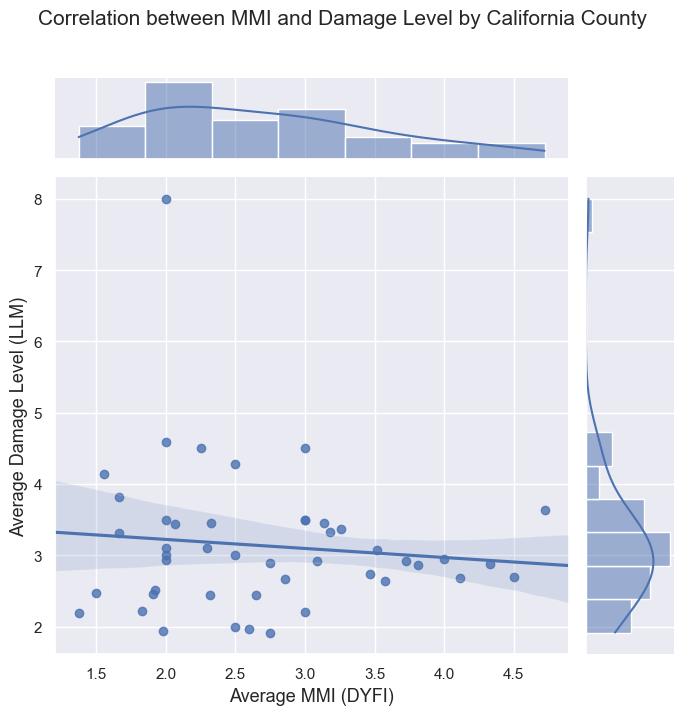


Number of California counties in analysis: 46

California counties in the analysis:
['Alameda County', 'Amador County', 'Butte County', 'Contra Costa County', 'El Dorado County', 'Fresno County', 'Imperial County', 'Inyo County', 'Kern County', 'Kings County', 'Lassen County', 'Los Angeles County', 'Madera County', 'Marin County', 'Mariposa County', 'Mendocino County', 'Merced County', 'Modoc County', 'Mono County', 'Monterey County', 'Napa County', 'Nevada County', 'Orange County', 'Placer County', 'Riverside County', 'Sacramento County', 'San Benito County', 'San Bernardino County', 'San Diego County', 'San Joaquin County', 'San Luis Obispo County', 'San Mateo County', 'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County', 'Shasta County', 'Siskiyou County', 'Solano County', 'Sonoma County', 'Stanislaus County', 'Sutter County', 'Tulare County', 'Tuolumne County', 'Ventura County', 'Yolo County', 'Yuba County']

First few rows of county-level data:
                county

In [48]:
 #Create the jointplot
g_1 = sns.jointplot(
    x="MMI_numeric",
    y="damage_level",
    data=county_data,
    kind="reg",
    truncate=False,
    color="b",
    height=7
)

# Set axis labels
g_1.set_axis_labels("Average MMI (DYFI)", "Average Damage Level (LLM)", fontsize=13)

# Add title
plt.suptitle("Correlation between MMI and Damage Level by California County", fontsize=15, y=1.02)

# Add correlation annotation using our function
annotate_corr_scatter(county_data['MMI_numeric'], county_data['damage_level'], g.ax_joint)

plt.tight_layout()
plt.show()

# Print some statistics
print("\nNumber of California counties in analysis:", len(county_data))
print("\nCalifornia counties in the analysis:")
print(county_data['county'].tolist())
print("\nFirst few rows of county-level data:")
print(county_data.head())

if the diff within +-1, we take them as same

In [65]:
 #Calculate absolute difference between MMI_numeric and damage_level
county_data['abs_diff'] = abs(county_data['MMI_numeric'] - county_data['damage_level'])

# Create a copy of the data
adjusted_data = county_data.copy()

# For points where difference < 1, set damage_level = MMI_numeric
adjusted_data.loc[adjusted_data['abs_diff'] < 1, 'damage_level'] = adjusted_data.loc[adjusted_data['abs_diff'] < 1, 'MMI_numeric']



In [72]:
print(adjusted_data)

                    county  MMI_numeric  damage_level  abs_diff
0           Alameda County     1.828472      1.828472  0.309855
1            Amador County     3.000000      4.500000  1.500000
2             Butte County     1.555556      4.088889  2.533333
3      Contra Costa County     1.923077      1.923077  0.602564
4         El Dorado County     2.500000      2.500000  0.500000
5            Fresno County     3.571429      3.571429  0.861905
6          Imperial County     3.133333      3.133333  0.400000
7              Inyo County     3.178571      3.178571  0.047256
8              Kern County     4.720779      4.720779  0.893747
9             Kings County     4.000000      2.950000  1.050000
10           Lassen County     1.666667      3.818182  2.151515
11      Los Angeles County     3.809781      3.809781  0.859276
12           Madera County     3.083333      3.083333  0.000000
13            Marin County     2.300000      2.300000  0.700000
14         Mariposa County     4.500000 

In [85]:
adjusted_data.to_csv('adjusted_data.csv', index=False)

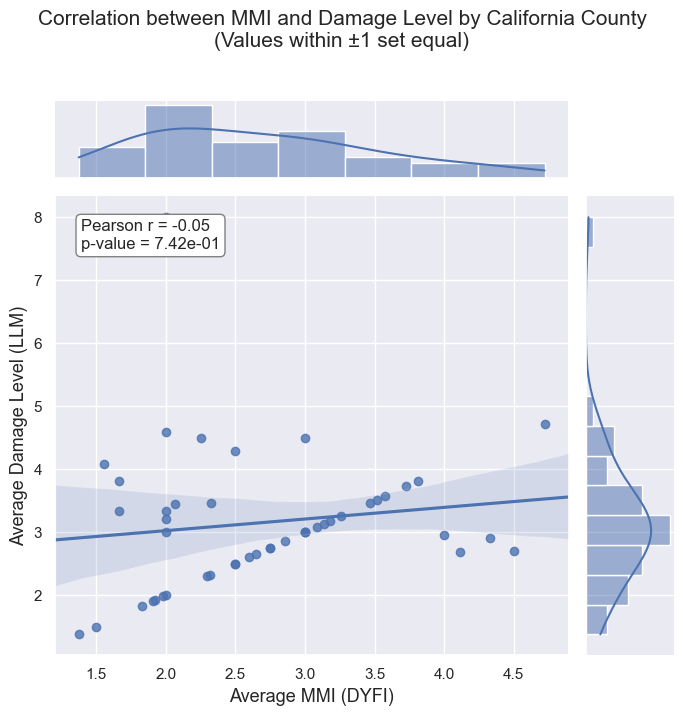

In [66]:
# Create the jointplot
g = sns.jointplot(
    x="MMI_numeric",
    y="damage_level",
    data=adjusted_data,
    kind="reg",
    truncate=False,
    color="b",
    height=7
)

# Set axis labels
g.set_axis_labels("Average MMI (DYFI)", "Average Damage Level (LLM)", fontsize=13)

# Add title
plt.suptitle("Correlation between MMI and Damage Level by California County\n(Values within ±1 set equal)", fontsize=15, y=1.02)

# Add correlation annotation using our function
annotate_corr_scatter(county_data['MMI_numeric'], county_data['damage_level'], g.ax_joint)

plt.tight_layout()
plt.show()

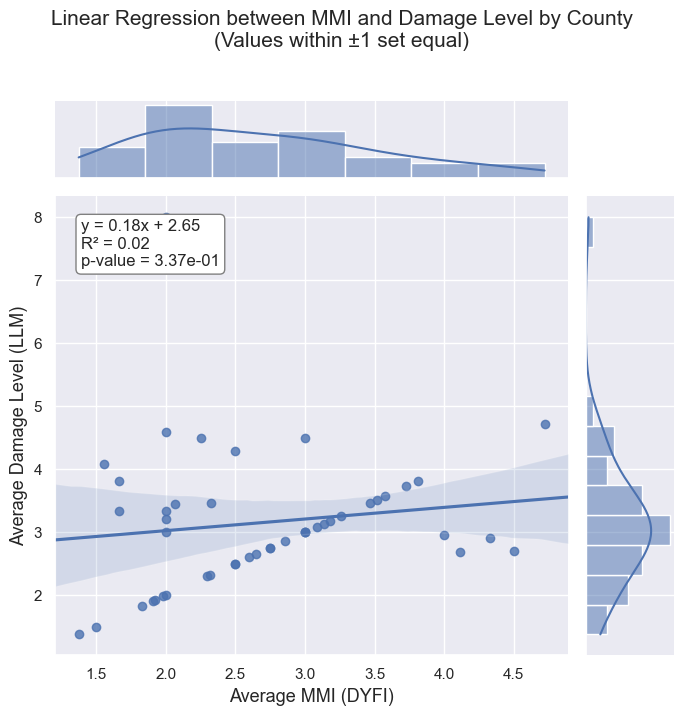

In [70]:
# Create the jointplot with regression
g = sns.jointplot(
    x="MMI_numeric",
    y="damage_level",
    data=adjusted_data,
    kind="reg",
    truncate=False,
    color="b",
    height=7
)

# Set axis labels
g.set_axis_labels("Average MMI (DYFI)", "Average Damage Level (LLM)", fontsize=13)

# Add title
plt.suptitle("Linear Regression between MMI and Damage Level by County\n(Values within ±1 set equal)", fontsize=15, y=1.02)

# Calculate regression statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(
    adjusted_data['MMI_numeric'].dropna(),
    adjusted_data['damage_level'].dropna()
)

# Add regression equation and R-squared to plot
g.ax_joint.annotate(
    f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}\np-value = {p_value:.2e}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1)
)

plt.tight_layout()
plt.show()

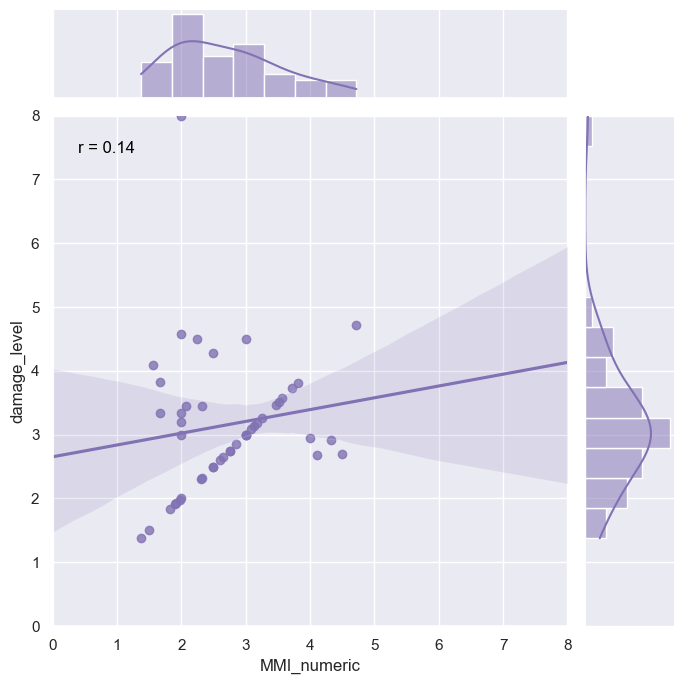

In [84]:



g = sns.jointplot(x="MMI_numeric", y="damage_level", data=adjusted_data,
                  kind="reg", truncate=False,
                  xlim=(0, 8), ylim=(0, 8),
                  color="m", height=7)


# Compute Pearson correlation
corr_coef, p_value = pearsonr(adjusted_data['MMI_numeric'], adjusted_data['damage_level'])

# Annotate correlation in upper-left corner of the plot
g.ax_joint.text(0.05, 0.95, f"r = {corr_coef:.2f}",
                transform=g.ax_joint.transAxes,
                fontsize=12, color='black',
                verticalalignment='top')

plt.show()

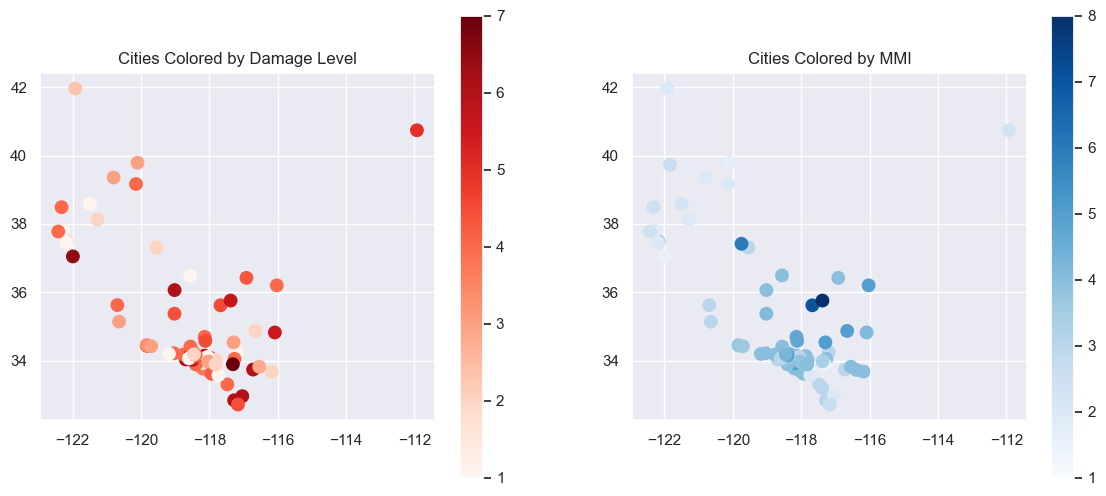

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt


# Plot by damage_level
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
gdf.plot(column='damage_level', cmap='Reds', legend=True, ax=ax[0], markersize=80)
ax[0].set_title('Cities Colored by Damage Level')
gdf.plot(column='MMI_numeric', cmap='Blues', legend=True, ax=ax[1], markersize=80)
ax[1].set_title('Cities Colored by MMI')
plt.show()

In [39]:
df3 = pd.read_csv('/Users/zihuima/Desktop/LLM_earthquake/Llava_final/merged_city_damage_mmi_latlon.csv')
# Qwen
merged = merged.rename(columns={'damage_level': 'qwen_damage_level'})
# Llava
df3 = df3.rename(columns={'damage_level': 'llava_damage_level'})

merged_all = pd.merge(
    merged,
    df3[['location_response_city', 'latitude', 'longitude', 'llava_damage_level']],
    on=['location_response_city', 'latitude', 'longitude'],
    how='inner'
)


In [40]:
print(merged_all.head())

  location_response_city  MMI_numeric  qwen_damage_level   latitude  \
0                Anaheim     4.000000           4.666667  33.834752   
1            Bakersfield     4.090909           4.400000  35.373871   
2           Baldwin Park     4.000000           4.000000  34.085474   
3              Bass Lake     3.000000           2.000000  37.310812   
4          Beverly Hills     4.333333           2.000000  34.069650   

    longitude  llava_damage_level  
0 -117.911732            1.627907  
1 -119.019463            1.697183  
2 -117.961176                 NaN  
3 -119.545003            1.000000  
4 -118.396306            1.235294  


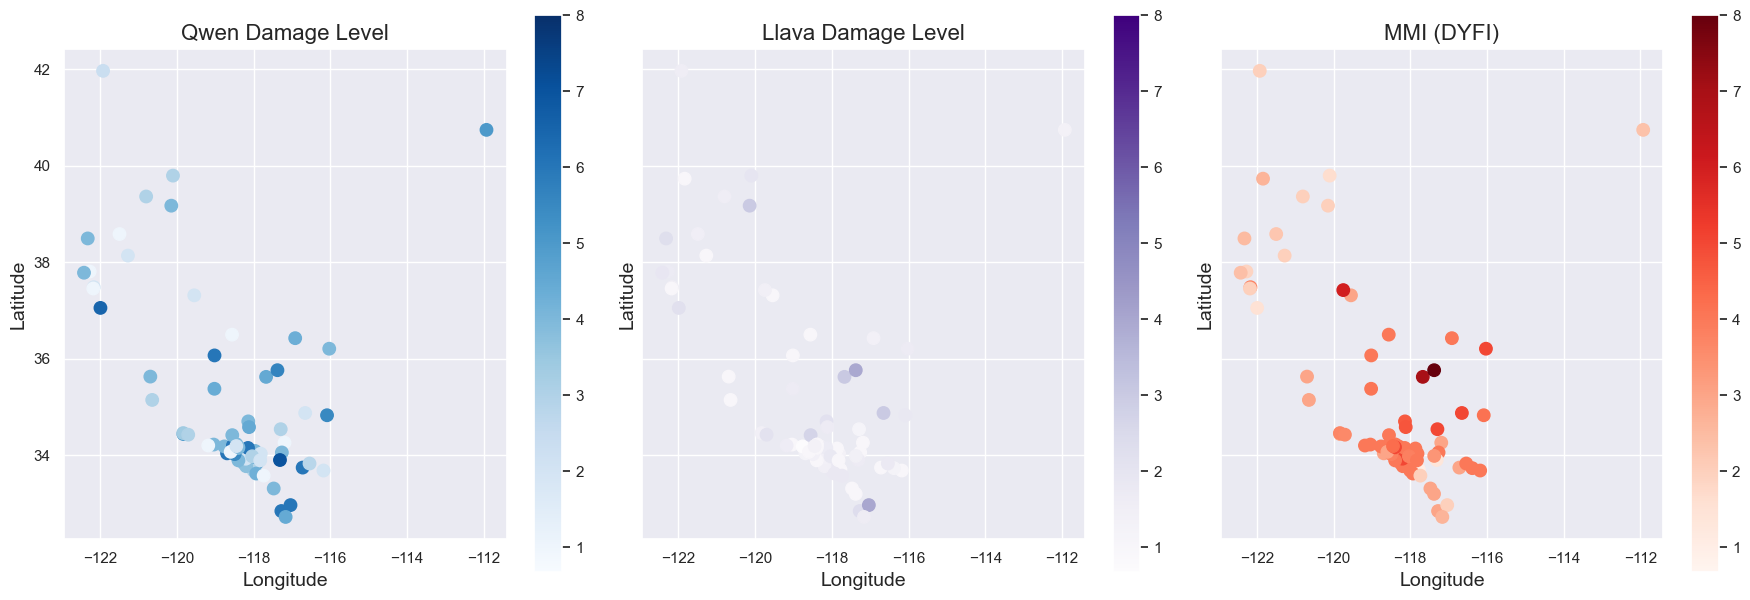

In [43]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style and Arial font
sns.set_theme(style="darkgrid")
plt.rcParams["font.family"] = "Arial"

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(merged_all['longitude'], merged_all['latitude'])]
gdf = gpd.GeoDataFrame(merged_all, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)

# Use the same color scale for all three
vmin = min(gdf['qwen_damage_level'].min(), gdf['llava_damage_level'].min(), gdf['MMI_numeric'].min())
vmax = max(gdf['qwen_damage_level'].max(), gdf['llava_damage_level'].max(), gdf['MMI_numeric'].max())

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

gdf.plot(column='qwen_damage_level', cmap='Blues', legend=True, ax=axes[0], markersize=80, vmin=vmin, vmax=vmax)
axes[0].set_title('Qwen Damage Level', fontsize=16)
axes[0].set_xlabel('Longitude', fontsize=14)
axes[0].set_ylabel('Latitude', fontsize=14)

gdf.plot(column='llava_damage_level', cmap='Purples', legend=True, ax=axes[1], markersize=80, vmin=vmin, vmax=vmax)
axes[1].set_title('Llava Damage Level', fontsize=16)
axes[1].set_xlabel('Longitude', fontsize=14)
axes[1].set_ylabel('Latitude', fontsize=14)

gdf.plot(column='MMI_numeric', cmap='Reds', legend=True, ax=axes[2], markersize=80, vmin=vmin, vmax=vmax)
axes[2].set_title('MMI (DYFI)', fontsize=16)
axes[2].set_xlabel('Longitude', fontsize=14)
axes[2].set_ylabel('Latitude', fontsize=14)

plt.tight_layout()
plt.show()

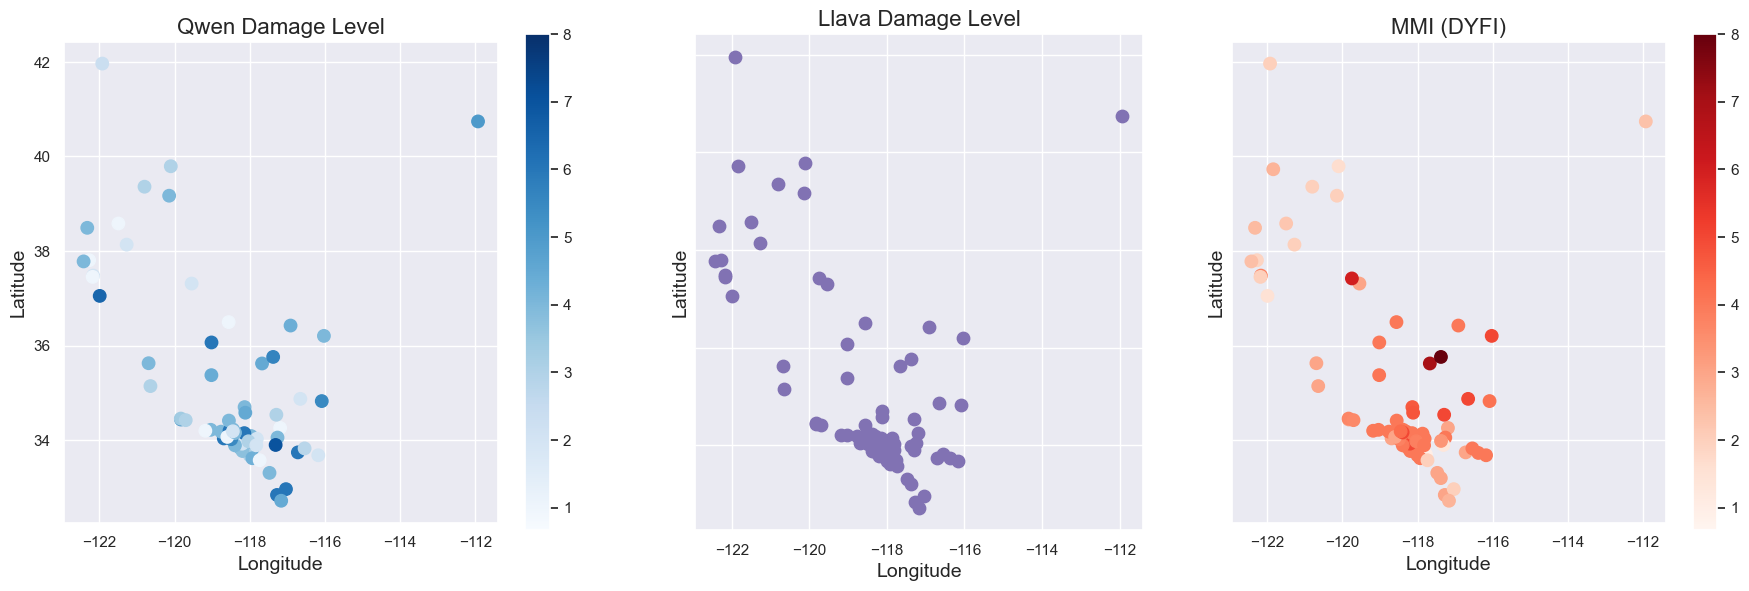

In [47]:


# Set Seaborn style and Arial font
sns.set_theme(style="darkgrid")
plt.rcParams["font.family"] = "Arial"

geometry = [Point(xy) for xy in zip(merged_all['longitude'], merged_all['latitude'])]
gdf = gpd.GeoDataFrame(merged_all, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

gdf.plot(column='qwen_damage_level', cmap='Blues', legend=True, ax=axes[0], markersize=80, vmin=vmin, vmax=vmax)
axes[0].set_title('Qwen Damage Level', fontsize=16)
axes[0].set_xlabel('Longitude', fontsize=14)
axes[0].set_ylabel('Latitude', fontsize=14)

gdf.plot(ax=axes[1], color='m', markersize=80, legend=True)
axes[1].set_title('Llava Damage Level', fontsize=16)
axes[1].set_xlabel('Longitude', fontsize=14)
axes[1].set_ylabel('Latitude', fontsize=14)

gdf.plot(column='MMI_numeric', cmap='Reds', legend=True, ax=axes[2], markersize=80, vmin=vmin, vmax=vmax)
axes[2].set_title('MMI (DYFI)', fontsize=16)
axes[2].set_xlabel('Longitude', fontsize=14)
axes[2].set_ylabel('Latitude', fontsize=14)

plt.tight_layout()
plt.show()

no more need

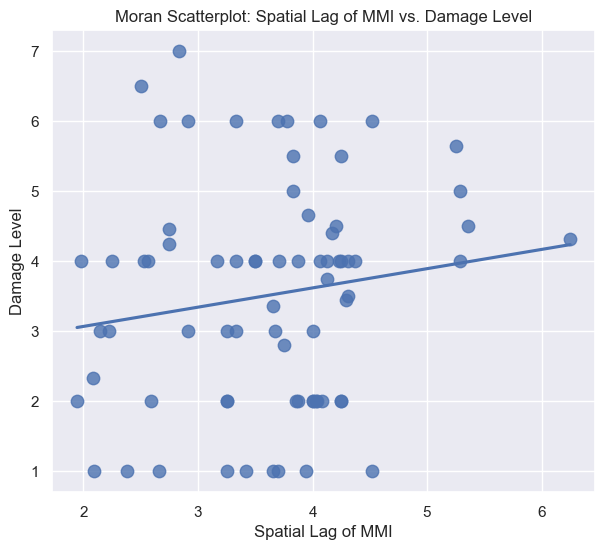

In [19]:
from libpysal.weights import KNN
from esda.moran import Moran_BV
import seaborn as sns

# Create spatial weights
w = KNN.from_dataframe(gdf, k=4)

# Calculate spatial lag of MMI_numeric
w.transform = 'r'
mmi_lag = w.sparse.dot(gdf['MMI_numeric'].values)

# Scatterplot: spatial lag of MMI vs. damage_level
plt.figure(figsize=(7, 6))
sns.regplot(x=mmi_lag, y=gdf['damage_level'], ci=None, scatter_kws={'s': 80})
plt.xlabel('Spatial Lag of MMI')
plt.ylabel('Damage Level')
plt.title('Moran Scatterplot: Spatial Lag of MMI vs. Damage Level')
plt.show()

In [20]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(merged['longitude'], merged['latitude'])]
gdf = gpd.GeoDataFrame(merged, geometry=geometry)

In [21]:
gdf.set_crs(epsg=4326, inplace=True)

,location_response_city,MMI_numeric,damage_level,latitude,longitude,geometry
0,Anaheim,4.000000,4.666667,33.834752,-117.911732,POINT (-117.91173 33.83475)
1,Bakersfield,4.090909,4.400000,35.373871,-119.019463,POINT (-119.01946 35.37387)
2,Baldwin Park,4.000000,4.000000,34.085474,-117.961176,POINT (-117.96118 34.08547)
3,Bass Lake,3.000000,2.000000,37.310812,-119.545003,POINT (-119.545 37.31081)
4,Beverly Hills,4.333333,2.000000,34.069650,-118.396306,POINT (-118.39631 34.06965)
...,...,...,...,...,...,...
80,Vancouver,2.000000,1.000000,33.573810,-117.734887,POINT (-117.73489 33.57381)
81,Victorville,5.000000,3.000000,34.536107,-117.291156,POINT (-117.29116 34.53611)
82,Washington,2.000000,3.000000,39.359342,-120.799108,POINT (-120.79911 39.35934)
83,Whittier,3.833333,3.000000,33.974914,-118.033866,POINT (-118.03387 33.97491)
